Import required packages

In [1]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from utils import *

import keras
from keras import callbacks
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop, SGD

from matplotlib.colors import ListedColormap
%matplotlib inline

Using TensorFlow backend.


**Q2.** Logistic regression algorithm using stochastic gradient descent to perform binary classification

In [2]:
def load_data(path, feature = 'raw'):
    """
    Loads data into pixel values from the list of path given. Returns 
    Input:
    - path (list): list of path to load the data from.
    - feature: either 'raw' or 'hist' for raw pixel values and 3D histogram respectively.
    """
    x_train=[]
    y_train=[]
    for c,i in enumerate(path):
        os.chdir(i)
        l = os.listdir()
        for i in l:
            if feature == 'raw':
                vf = convert2pixel_value(i)
            else:
                vf = convert2color_3Dhist(i)
            x_train.append(vf)
            y_train.append(c)
    
    x_train = np.concatenate([i[np.newaxis] for i in x_train])
    y_train = np.array(y_train)
    
    # comment below to remove the shuffling of the data
    arr = np.arange(x_train.shape[0])
    np.random.shuffle(arr)
    x_train = x_train[arr]
    y_train = y_train[arr]
    
    return x_train, y_train

Define the path to the directories containing the images then load the data set using `load_data`.

In [3]:
train_bird = "C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/train/bird"
train_cat = "C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/train/cat"
test_bird = "C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/test/bird"
test_cat = "C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/test/cat"

Load the data from `bird` and `cat` folders, and we shall let `x1`, `y1` refer to the raw pixel value feature and `x2`, `y2` refer to the feature obtained by using the 3D histogram in this jupyter notebook.

In [4]:
x1_train, y1_train = load_data([train_cat, train_bird])
x1_test, y1_test = load_data([test_cat, test_bird])

In [5]:
x1_train.shape

(40, 3072)

We do some preprocessing of the training data by normalizing the pixel values to between $[0,1]$ and the labels to be $\{-1,+1\}$.

In [6]:
def add_bias(dataset):
    """
    Add a one to each sample for bias. Dataset must be of the form rows: samples, columns: features
    """
    n, m = dataset.shape
    out = np.ones((n, m+1))
    out[:,:-1] = dataset
    return out    

In [7]:
x1_train = x1_train/255
x1_test = x1_test/255
y1_train = y1_train*2 - 1
y1_test = y1_test*2 - 1

In [8]:
x1_train = add_bias(x1_train)
x1_test = add_bias(x1_test)

In [9]:
print (x1_train.shape[0], 'training samples')
print (x1_test.shape[0], 'test samples')

40 training samples
40 test samples


Define some basic functions for computing the loss and gradient of the model

In [10]:
def sigmoid(x):
    """
    Applies the sigmoid function on the given vector.
    Input(s):
    - x : numpy vector of values
    """
    return 1/(1+np.exp(-x))

In [11]:
def initialize_params(size=3073, seed=123):
    """
    Initialize parameters W weights and b biases.
    Input(s):
    - size (int): size of the parameters
    - seed (int): seed for the random number generator
    """
    rng = np.random.RandomState(seed)
    
    return rng.normal(size=(size,))

In [12]:
def log_loss(x_train, y_train, W):
    """
    Computes the loss value of the logistic loss.
    Input(s):
    - x_train, y_train: training data and labels. x_train takes different forms depending on the features used and y_train
                        is {-1,+1}.
    - W: value of the parameters.                    
    """
    z = y_train * np.dot(x_train, W)
    h = sigmoid(z)
    
    return -np.mean(np.log(h))   

In [13]:
def log_grad(x_train, y_train, W):
    """
    Computes the gradient of the logistic loss function.
    Input(s):
    - x_train, y_train: training data and labels. x_train takes different forms depending on the features used and y_train
                        is {-1,+1}.
    - W: value of the parameters.                    
    """
    z = y_train * np.dot(x_train, W)
    h = sigmoid(z)
    n = x_train.shape[0]
    
    return 1/n * np.dot(x_train.T,(y_train * (h-1)))    

In [14]:
def next_batch(x_train, y_train, batch_size=2):
    """
    Returns a batch of size batch_size for stochastic gradient descent.
    - x_train, y_train: training data and labels. x_train takes different forms depending on the features used and y_train
                        is {-1,+1}.
    - batch_size (int): size of each batch.                    
    """
    for i in np.arange(0, x_train.shape[0], batch_size):
        yield (x_train[i:i+batch_size],y_train[i:i+batch_size])


In [15]:
def log_classifier(x, learnt_W):
    """
    Takes in the test set and learnt parameters and returns the accuracy of the classifier on the test set.
    Inputs:
    -
    """
    return (sigmoid(np.dot(x, learnt_W)) >= .5) * 2 - 1

In [16]:
def log_accuracy(x, y, learnt_W):
    """
    Returns the accuracy of the model with parameters learnt_W.
    Input(s):
    - 
    """
    output = log_classifier(x, learnt_W)
    return np.sum(np.absolute(y - output) == 0)/y.shape[0]

In [17]:
def log_train(x_train, y_train, x_test, y_test, W, alpha=0.01, batch_size = 4, epoch = 100):
    """
    Trains the model with given learning rate alpha, batch_size, epoch and initialized parameters W.
    """
    loss_history = []
    train_acc_history = []
    test_acc_history = []
    for e in np.arange(epoch):
        epoch_loss = []
        for (batchx, batchy) in next_batch(x_train, y_train):
            loss = log_loss(batchx, batchy, W)
            grad = log_grad(batchx, batchy, W)
            epoch_loss.append(loss)
            W += -alpha * grad
        loss_history.append(np.average(epoch_loss))
        train_acc = log_accuracy(x_train, y_train, W)
        test_acc = log_accuracy(x_test, y_test, W)
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
    
    return loss_history, train_acc_history, test_acc_history, W    

In [18]:
def display_plot(loss_history, train_acc_history, test_acc_history):
    """
    Plots out the loss function value for the different epochs and the accuracy of the test set for the 
    parameters learnt in the different epochs.
    Input(s):
    - loss_history: list containing the change in the loss value over the epochs
    - acc_history: list containing the accuracy value of the test set over the epochs
    """
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    ax1.plot(loss_history, color='r')
    # ax1.plot(model_log.history['val_acc'])
    ax1.set_title('Loss (Lower Better)')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    ax1.legend(['train', 'validation'], loc='upper right')

    ax2.plot(train_acc_history)
    ax2.plot(test_acc_history)
    ax2.set_title('Accuracy (Higher Better)')
    ax2.set(xlabel='Epoch', ylabel='Accuracy')
    ax2.legend(['train', 'test'], loc='center right')

Here `W1` refers to the initialized parameters that will be used to learn the model from using the raw pixel values as the training data.

In [19]:
W1 = initialize_params(seed=1)
loss_history1, train_acc_history1, test_acc_history1, learnt_W1 = log_train(x1_train, y1_train, x1_test, y1_test, W1, epoch=100)

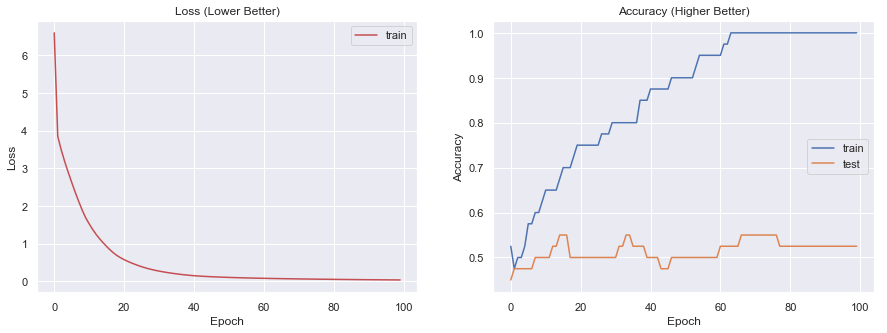

In [20]:
display_plot(loss_history1, train_acc_history1, test_acc_history1)

3D histogram

In [21]:
x2_train, y2_train = load_data([train_cat, train_bird], feature = None)
x2_test, y2_test = load_data([test_cat, test_bird], feature=None)

In [22]:
print (x2_train.shape)

(40, 512)


In [23]:
# xh_train = xh_train/1024
# xh_test = xh_test/1024
y2_train = y2_train*2 - 1
y2_test = y2_test*2 - 1

In [24]:
x2_train = add_bias(x2_train)
x2_test = add_bias(x2_test)

In [25]:
print (x2_train.shape)

(40, 513)


In [26]:
W2 = initialize_params(size = x2_train.shape[1], seed=1)
loss_history2, train_acc_history2, test_acc_history2, learnt_W2 = log_train(x2_train, y2_train, x2_test, y2_test, W2, epoch=100)

C:\Users\zlai\AppData\Local\Continuum\anaconda3\envs\mlhw\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


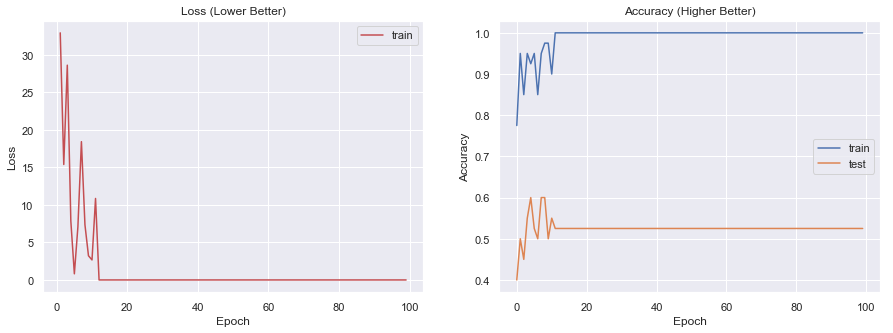

In [27]:
display_plot(loss_history2, train_acc_history2, test_acc_history2)

**Q3.** Hinge loss with stochastic gradient descent to perform binary classification

As in earlier, we will use `1` and `2` labels to reference using the raw pixel values and the features from the histogram respectively.

In [28]:
def hinge_loss(x_train, y_train, W ):
    """
    Returns the value 
    """
    z = y_train * np.dot(x_train, W)
    return np.average(np.maximum(1-z,0))

In [29]:
def hinge_grad(x_train, y_train, W):
    """
    
    """
    z = y_train * np.dot(x_train, W)
    grad = -(y_train * x_train.T).T
    grad[z>1]=0
    return np.average(grad, axis=0)

Here we shall use `theta` to represent the parameters.

In [30]:
def hinge_classifier(x, learnt_theta):
    """
    
    """
    return np.sign(np.dot(x,learnt_theta))

In [31]:
def hinge_accuracy(x, y, learnt_theta):
    """
    
    """
    output = hinge_classifier(x, learnt_theta)
    return np.sum(np.absolute(y - output) == 0)/y.shape[0]   

In [32]:
def hinge_train(x_train, y_train, x_test, y_test, theta, alpha=0.01, batch_size = 1, epoch = 100):
    """
    
    """
    loss_history = []
    train_acc_history = []
    test_acc_history = []
    for e in np.arange(epoch):
        epoch_loss = []
        for (batchx, batchy) in next_batch(x_train, y_train):
            loss = hinge_loss(batchx, batchy, theta)
            grad = hinge_grad(batchx, batchy, theta)
            epoch_loss.append(loss)
            theta += -alpha * grad
        loss_history.append(np.average(epoch_loss))
        train_acc = log_accuracy(x_train, y_train, theta)
        test_acc = log_accuracy(x_test, y_test, theta)
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
    
    return loss_history, train_acc_history, test_acc_history, theta

In [33]:
theta1 = initialize_params(size = x1_train.shape[1])
loss_history1, train_acc_history1, test_acc_history1, learnt_theta1 = hinge_train(x1_train, y1_train, x1_test, y1_test, theta1, epoch = 100)

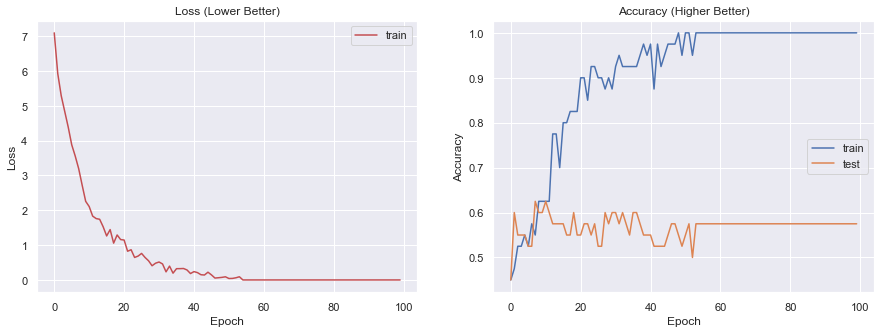

In [34]:
display_plot(loss_history1, train_acc_history1, test_acc_history1)

Using the features from the histogram

In [35]:
theta2 = initialize_params(size = x2_train.shape[1])
loss_history2, train_acc_history2, test_acc_history2, learnt_theta2 = hinge_train(x2_train, y2_train, x2_test, y2_test, theta2, epoch = 100)

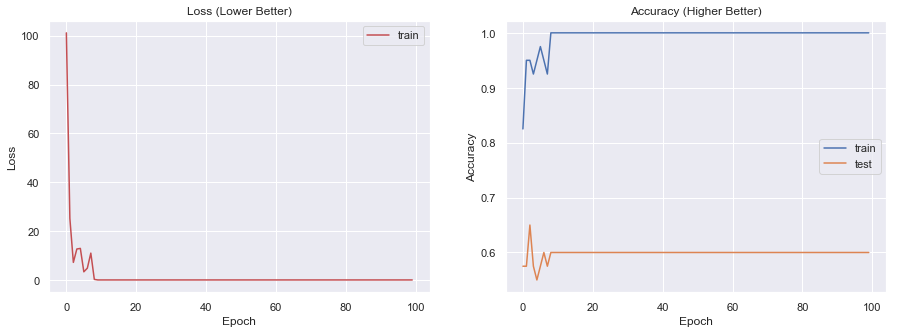

In [36]:
display_plot(loss_history2, train_acc_history2, test_acc_history2)